# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).

# Load data

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

batch_size = 128
transforms = transforms.ToTensor()

trainset = datasets.SVHN('data', download=True, split='train', transform=transforms)
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)

Using downloaded and verified file: data\train_32x32.mat


### Visualize

In [5]:
images, labels = next(iter(train_loader))
print(images.shape)

torch.Size([128, 3, 32, 32])


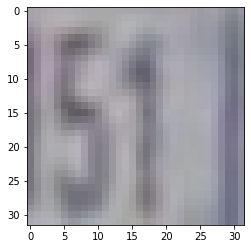

In [6]:
# one image
img = images[0].permute(1, 2, 0)
plt.imshow(img)
plt.show()

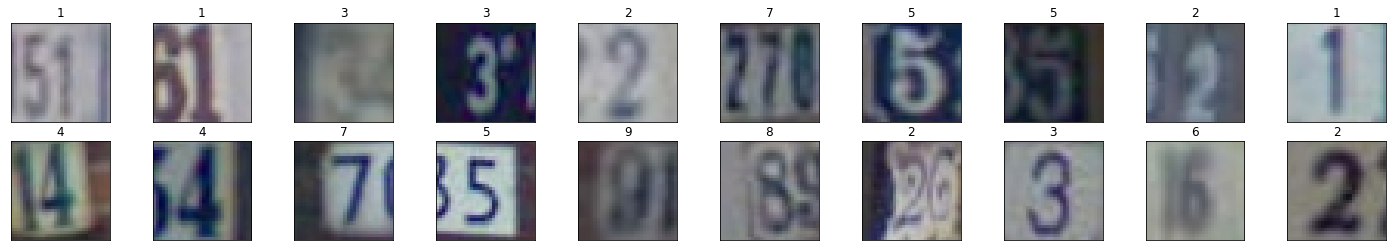

In [7]:
# several images
fig = plt.figure(figsize=(25, 4))
num_plot = 20

for i in range(num_plot):
    ax = fig.add_subplot(2, num_plot/2, i+1, xticks=[], yticks=[])
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(str(labels[i].item()))

### Scaling

In [8]:
print('Máx value:', images[0].max())
print('Min value:', images[0].min())

Máx value: tensor(0.7333)
Min value: tensor(0.3569)


In [9]:
def scale(img, feature_range=(-1, 1)):
    
    min_, max_ = feature_range
    img = img * (max_ - min_) + min_
    return img

In [10]:
img = scale(images[0])
print('Máx value:', img.max())
print('Min value:', img.min())

Máx value: tensor(0.4667)
Min value: tensor(-0.2863)


# Model

## Discriminator

Here you'll build the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 

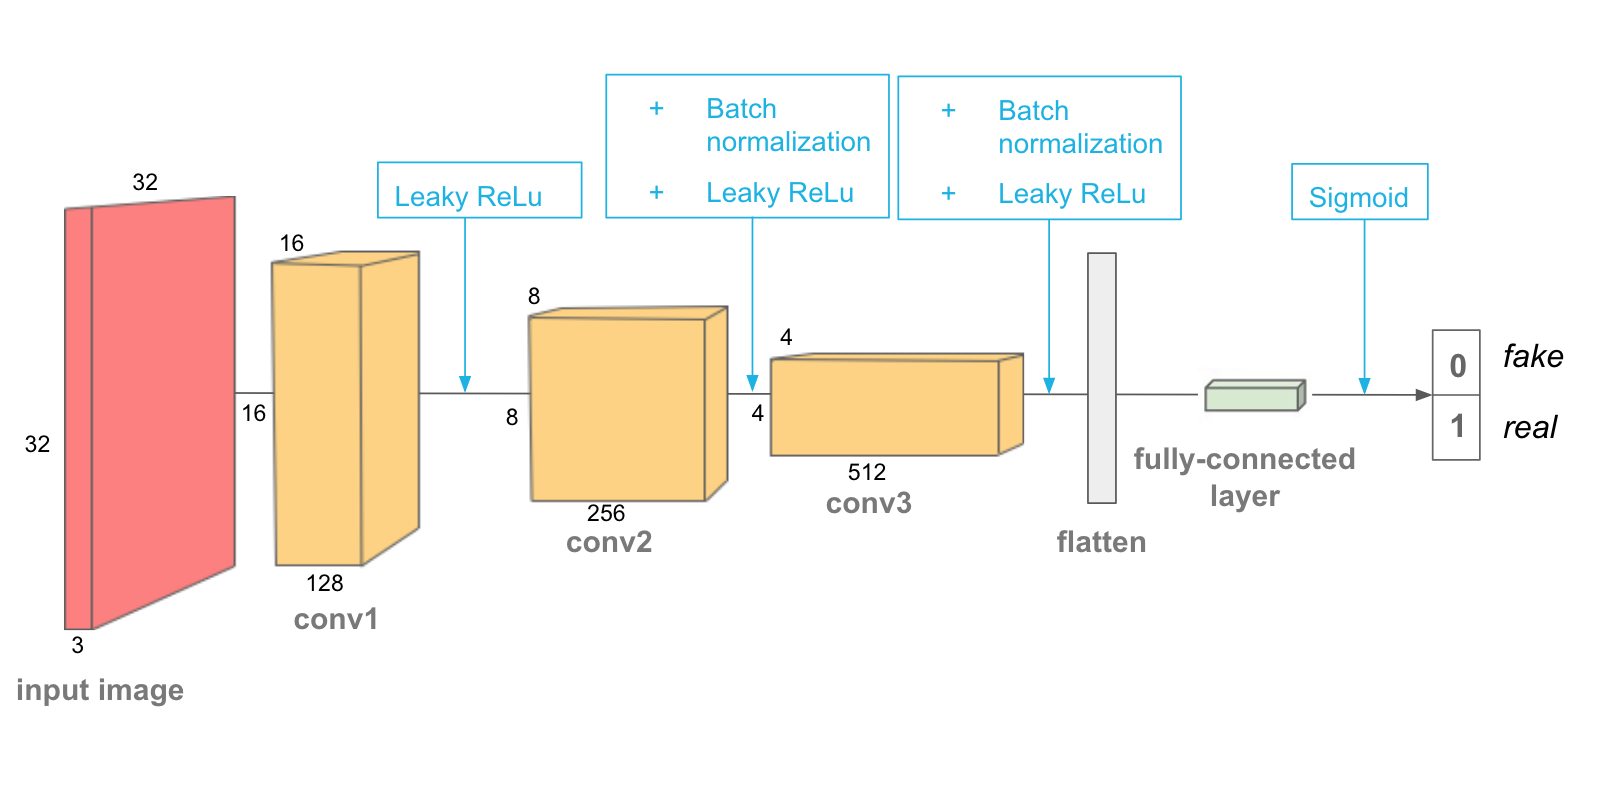

In [11]:
from IPython.display import Image

Image(filename='assets/conv_discriminator.png', width='80%')

In [12]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        batch = nn.BatchNorm2d(out_channels)
        layers.append(batch)
        
    return nn.Sequential(*layers)

In [13]:
# eg.
conv1 = conv(3, 32, 4)
conv1

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, cov_dim=32):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, cov_dim, 4, batch_norm=False) # input=32x32x3 out=16x16xconv_dim 
        self.conv2 = conv(cov_dim, conv_dim*2, 4) # out=8x8xconv*2 
        self.conv3 = conv(cov_dim*2, conv_dim*4, 4) #4x4xconv*4
        
        self.fc = nn.Linear(4*4*conv_dim*4, 1)
        
    def forward(self, x):
        # conv
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        # flatten
        x = x.view(-1, 4*4*self.conv_dim*4)
        #fully connected layer
        x = self.fc(x)
        
        return x

## Generator

Next, you'll build the generator network. The input will be our noise vector `z`, as before. And, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

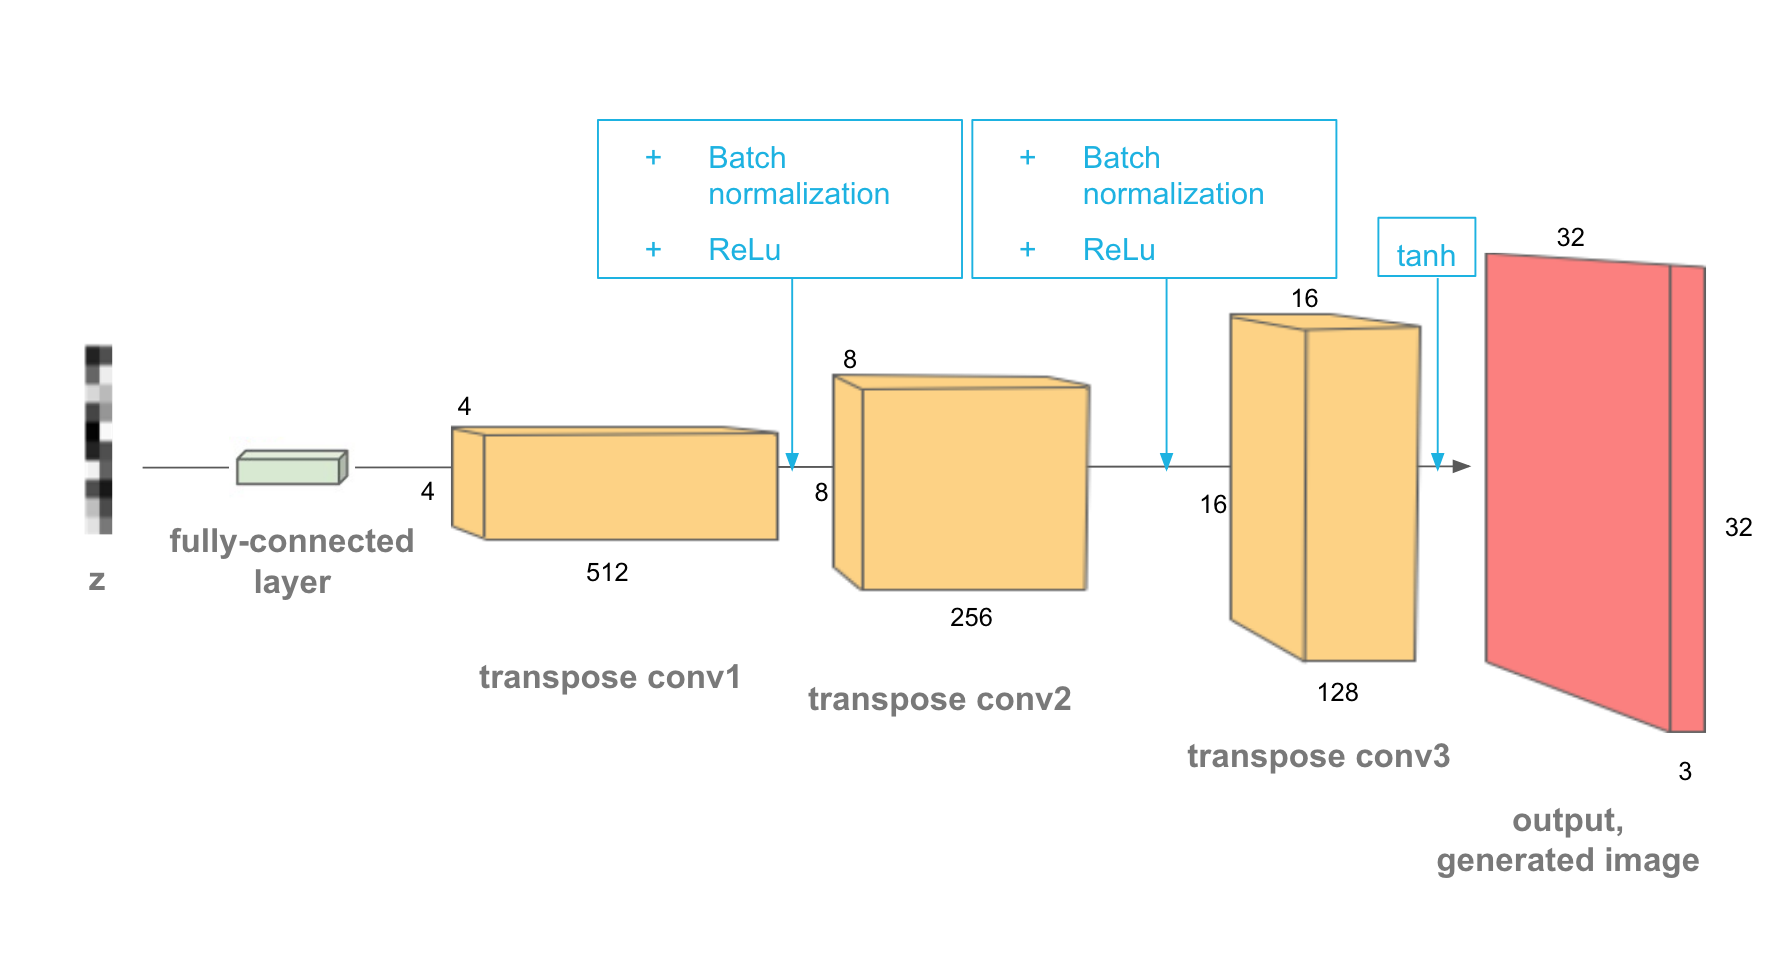

In [15]:
Image(filename='assets/conv_generator.png', width='80%')

In [16]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(deconv_layer)
    
    if batch_norm:
        batch = nn.BatchNorm2d(out_channels)
        layers.append(batch)
        
    return nn.Sequential(*layers)

In [17]:
# eg.
deconv1 = deconv(64, 32, 4)
deconv1

Sequential(
  (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [18]:
class Generator(nn.Module):
    def __init__(self, z_size, cov_dim=32):
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, 4*4*conv_dim*4)
        
        self.t_conv1 = deconv(4*conv_dim, 2*conv_dim, 4)
        self.t_conv2 = deconv(2*conv_dim, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

        
    def forward(self, x):
        # fully-connected + reshape 
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        # last transpose conv layer + tanh
        x = torch.tanh(self.t_conv3(x))

        return x

## Build complete network

In [19]:
# hyperparams
conv_dim = 32
z_size = 100

D = Discriminator(conv_dim)
G = Generator(z_size, conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Train on GPU

In [20]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    D.cuda()
    G.cuda()
    print('GPU available! Models move to GPU')
else:
    print('Work on CPU')

GPU available! Models move to GPU


## Discriminator and Generator Losses

In [21]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.shape[0]
    
    if smooth:
        labels = torch.ones(batch_size)*0.9 # real = 1
    else:
        labels = torch.ones(batch_size)
        
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.shape[0]
    labels = torch.zeros(batch_size) # fake = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss  

# Training

## Optimizer

In [22]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [24]:
import pickle as pkl

epochs = 30
print_every = 500

losses, samples = [], []

sample_size = 16
sample_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
sample_z = torch.from_numpy(sample_z).float()

D.train()
G.train()
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.shape[0]
        # rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
        
        # 1. real images
        if train_on_gpu:
            real_images = real_images.cuda()
            
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        if train_on_gpu:
            z = z.cuda()
        
        fake_images = G(z)
    
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # 3. loss and backpropagation
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        g_optimizer.zero_grad()
        
        # 1. generator loss
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        if train_on_gpu:
            z = z.cuda()
            
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # 2. backpropagation 
        g_loss.backward()
        g_optimizer.step()
        
        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch {}/{} | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, epochs, d_loss.item(), g_loss.item()))
    
    
    G.eval()
    if train_on_gpu:
        sample_z = sample_z.cuda()
    fake_images = G(sample_z)
    samples.append(fake_images)
    G.train()
        
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)         

Epoch 1/30 | d_loss: 0.1988 | g_loss: 3.5037
Epoch 1/30 | d_loss: 0.6787 | g_loss: 4.1544
Epoch 2/30 | d_loss: 0.3671 | g_loss: 2.4469
Epoch 2/30 | d_loss: 0.0808 | g_loss: 3.9736
Epoch 3/30 | d_loss: 0.1338 | g_loss: 2.9566
Epoch 3/30 | d_loss: 0.0840 | g_loss: 3.8302
Epoch 4/30 | d_loss: 0.2255 | g_loss: 3.3191
Epoch 4/30 | d_loss: 0.1560 | g_loss: 3.1085
Epoch 5/30 | d_loss: 0.1968 | g_loss: 3.9417
Epoch 5/30 | d_loss: 1.1172 | g_loss: 0.4682
Epoch 6/30 | d_loss: 0.1562 | g_loss: 3.5924
Epoch 6/30 | d_loss: 0.4183 | g_loss: 2.4207
Epoch 7/30 | d_loss: 0.4486 | g_loss: 4.5535
Epoch 7/30 | d_loss: 0.3150 | g_loss: 3.5569
Epoch 8/30 | d_loss: 0.4565 | g_loss: 3.0991
Epoch 8/30 | d_loss: 0.1287 | g_loss: 4.8747
Epoch 9/30 | d_loss: 0.0996 | g_loss: 3.9313
Epoch 9/30 | d_loss: 0.2575 | g_loss: 4.3791
Epoch 10/30 | d_loss: 0.1760 | g_loss: 2.5205
Epoch 10/30 | d_loss: 0.1956 | g_loss: 2.8610
Epoch 11/30 | d_loss: 0.1073 | g_loss: 3.1902
Epoch 11/30 | d_loss: 0.0907 | g_loss: 4.0075
Epoch 

### Training loss

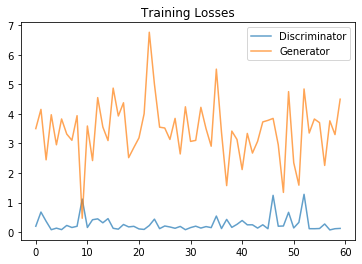

In [26]:
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.7)
plt.plot(losses.T[1], label='Generator', alpha=0.7)
plt.title("Training Losses")
plt.legend()
plt.show()

## Generator samples from training

In [27]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [28]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

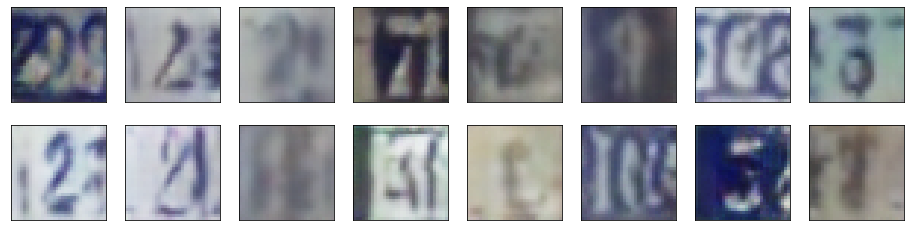

In [29]:
# last epoch
view_samples(-1, samples)